### Python code that will analyze the recharge potential for each "Area No." based on the 4-year groundwater dataset (2021-2024) and extract the top 5 locations per area with the highest recharge potential.

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# File paths for 2021-2024
file_path_2021 = "../dataset/chennai-ground-water-levels-2021.csv"
file_path_2022 = "../dataset/chennai-ground-water-levels-2022.csv"
file_path_2023 = "../dataset/chennai-ground-water-levels-2023.csv"
file_path_2024 = "../dataset/chennai-ground-water-levels-2024.csv"

In [3]:
# Load datasets
df_2021 = pd.read_csv(file_path_2021)
df_2022 = pd.read_csv(file_path_2022)
df_2023 = pd.read_csv(file_path_2023)
df_2024 = pd.read_csv(file_path_2024)

In [4]:
# List of monthly columns
monthly_columns = ["Jan ", "Feb", "Mar", "Apr ", "May", "Jun", 
                   "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [5]:
# Data Preparation: Ensure all datasets have necessary columns
def prepare_data(df, year=None):
    if year == 2024:
        df[monthly_columns[3:]] = np.nan  # Set Apr-Dec to NaN for 2024
    df[monthly_columns] = df[monthly_columns].apply(pd.to_numeric, errors='coerce')
    df["Yearly Average"] = df[monthly_columns].mean(axis=1)
    return df

In [6]:
# Apply preparation function
df_2021 = prepare_data(df_2021, 2021)
df_2022 = prepare_data(df_2022, 2022)
df_2023 = prepare_data(df_2023, 2023)
df_2024 = prepare_data(df_2024, 2024)

# Add Year Column
df_2021["Year"] = 2021
df_2022["Year"] = 2022
df_2023["Year"] = 2023
df_2024["Year"] = 2024

# Combine all datasets
df_all_years = pd.concat([df_2021, df_2022, df_2023, df_2024])

In [7]:
# Step 1: Identify Wards with Significant Post-Monsoon Rises
df_all_years["Post-Monsoon Rise"] = df_all_years["Oct"] - df_all_years["Jun"]
# Compute mean post-monsoon rise
mean_rise = df_all_years.groupby("Year")["Post-Monsoon Rise"].mean()

In [8]:
# Flag wards with significant rises (greater than yearly mean rise)
df_all_years["Recharge Potential"] = df_all_years.apply(
    lambda row: "High" if row["Post-Monsoon Rise"] > mean_rise[row["Year"]] else "Low", axis=1
)

In [9]:
# Compute overall recharge potential score (average across years)
recharge_potential_scores = df_all_years.groupby(["Location", "Area No."])["Post-Monsoon Rise"].mean().reset_index()

In [10]:
# Rank locations within each "Area No." based on recharge potential
recharge_potential_scores["Rank"] = recharge_potential_scores.groupby("Area No.")["Post-Monsoon Rise"].rank(ascending=False)

In [11]:
# Get top 5 locations per "Area No."
top_recharge_locations = recharge_potential_scores.groupby("Area No.").apply(lambda x: x.nsmallest(5, "Rank")).reset_index(drop=True)

# Display results
print("Top 5 Locations in Each 'Area No.' with Highest Recharge Potential:")
print(top_recharge_locations)

Top 5 Locations in Each 'Area No.' with Highest Recharge Potential:
                Location Area No.  Post-Monsoon Rise  Rank
0             Sathankadu        I           1.569333   1.0
1   Chinna Mettupalaiyam        I           0.140333   2.0
2         Thilagar Nagar        I           0.096333   3.0
3            Kathivakkam        I          -0.066000   4.0
4               Ernavoor        I          -0.075333   5.0
..                   ...      ...                ...   ...
65               Uthandi       XV           1.183333   1.0
66           Neelankarai       XV           0.143500   2.0
67  Okkiyam Thuraipakkam       XV          -0.232667   3.0
68           Injampakkam       XV          -0.296000   4.0
69           Semmenchery       XV          -0.508333   5.0

[70 rows x 4 columns]


C:\Users\rumma\AppData\Local\Temp\ipykernel_20772\640185364.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_recharge_locations = recharge_potential_scores.groupby("Area No.").apply(lambda x: x.nsmallest(5, "Rank")).reset_index(drop=True)


In [12]:
# Save to CSV for further analysis
output_file = "./top_recharge_potential_locations.csv"
top_recharge_locations.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Results saved to ./top_recharge_potential_locations.csv


C:\Users\rumma\AppData\Local\Temp\ipykernel_20772\813142723.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top10_rise, x="Location", y="Post-Monsoon Rise", palette="Blues_r")
C:\Users\rumma\AppData\Local\Temp\ipykernel_20772\813142723.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


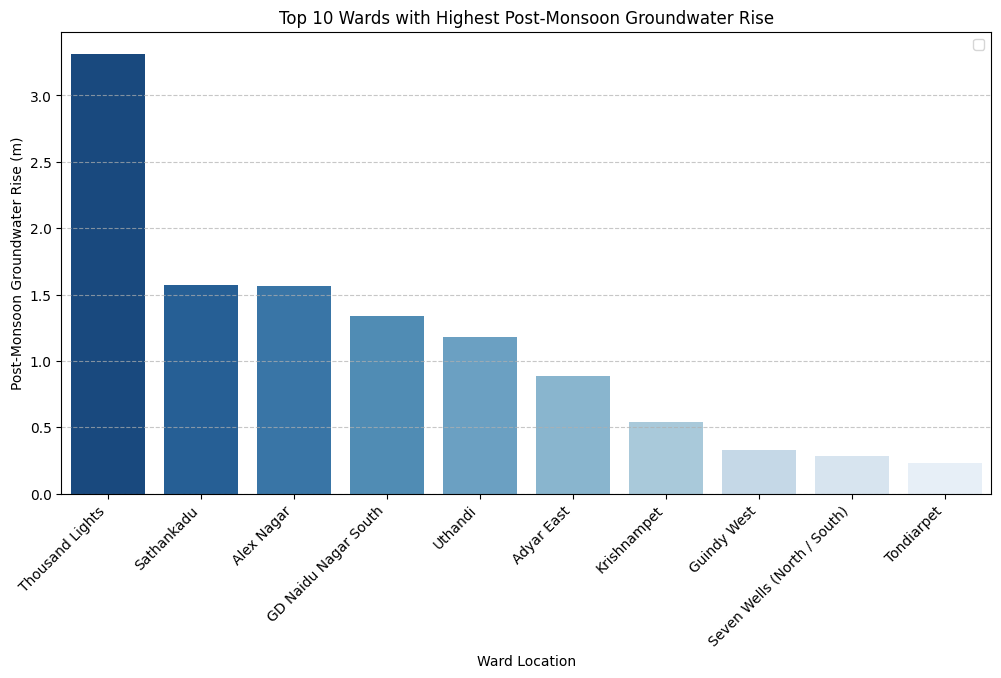

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load processed dataset
df_all_years = pd.read_csv("./top_recharge_potential_locations.csv")

# Sort wards by post-monsoon rise and select the top 10
df_top10_rise = df_all_years.sort_values("Post-Monsoon Rise", ascending=False).head(10)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top10_rise, x="Location", y="Post-Monsoon Rise", palette="Blues_r")

plt.xlabel("Ward Location")
plt.ylabel("Post-Monsoon Groundwater Rise (m)")
plt.title("Top 10 Wards with Highest Post-Monsoon Groundwater Rise")
plt.xticks(rotation=45, ha="right")
# plt.axhline(df_all_years["Post-Monsoon Rise"].mean(), color="red", linestyle="--", label="Mean Rise")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save figure
plt.savefig("output/Post-Monsoon_Rise_Top10.png", dpi=300, bbox_inches="tight")
plt.show()
